In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from pydrake.all import (
    ControllabilityMatrix,
    DiagramBuilder,
    Linearize,
    LinearQuadraticRegulator,
    MeshcatVisualizer,
    Saturation,
    SceneGraph,
    Simulator,
    StartMeshcat,
    WrapToSystem,
    LinearSystem
)
from pydrake.examples import AcrobotGeometry, AcrobotInput, AcrobotPlant, AcrobotState

meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [80]:
def UprightState():
    state = AcrobotState()
    state.set_theta1(np.pi)
    state.set_theta2(0.0)
    state.set_theta1dot(0.0)
    state.set_theta2dot(0.0)
    return state

The singular values of the controllability matrix are: [5.11718692e+02 1.23084288e+02 8.06819874e-02 7.15326677e-02]


In [22]:
from IPython.display import SVG, display, clear_output, Markdown
from control.models.acrobot import Acrobot2DModel
from control.iLQRController import iLQR

Q = np.diag(np.concatenate(([1.0] * 2, [0.1] * 2)))
Qf = np.diag(np.concatenate(([100.0] * 2, [100.0] * 2)))
R = np.diag([0.01])
dt = 0.05
N = 40

iLQRParams = {
    "Q" : Q,
    "R" : R,
    "Qf" : Qf,
    "N" : N,
    "dt" : dt,
    "max_iter" : 20,
    "max_linesearch_iters": 10,
    "integration": "RK4",
}
plant = Acrobot2DModel(**iLQRParams)
controller = iLQR(plant, **iLQRParams)
goal_state  = np.array([np.pi, 0., 0., 0.])
current_state = np.array([0., 0., 0., 0.])
# current_state = np.array([ 2.83752567,  0.7953031,   0.0177701,  -0.2012475 ])
nx, nu = plant.get_dims()
uref = np.zeros(nu, dtype = np.float64)
xtraj = np.zeros((N, nx))
utraj = np.zeros((N-1, nu))
controller.model.set_references(goal_state, uref)

# print(controller.model.discrete_dynamics(goal_state, 0))
# print(controller.model.xdot_fun(goal_state, 0))
state_error = 0
time = 0

state_log = current_state
action_log = None
while np.linalg.norm(state_error) > 1e-4 or time == 0:
    if not utraj.any():
        utraj[:] = np.random.randn(N-1, nu)*1.0
    else:
        # Use previous utraj as initial guess with shifting 
        # forward a single timestep, 
        utraj[:-1, :] = utraj[1:,:] #+  np.random.randn(N-2, nu)

    xtraj, utraj = controller.run_ilqr(current_state, utraj)
    current_state = xtraj[1, :]
    u = utraj[0, :]
    current_state = np.squeeze(current_state)

    state_error = current_state - goal_state
    state_error[:2] /= np.pi
    terminal_state_error = xtraj[-1, :] - goal_state
    terminal_state_error[:2] /= np.pi
    # print(xtraj)
    clear_output(wait=True)
    display(Markdown(f"**t = {time:4.4f}s:**\n```\nError: {state_error}\n```\n**Control:**\n```\n{u}\n```\n**Terminal State Err:**\n```\n{terminal_state_error}"))
    time += dt

    state_log = np.vstack((state_log, current_state))
    action_log = np.vstack((action_log, u)) if action_log is not None else u


**t = 6.5000s:**
```
Error: [-5.65552670e-06 -1.23159001e-05  3.89594698e-05  8.35400659e-05]
```
**Control:**
```
[0.00012965]
```
**Terminal State Err:**
```
[-2.65735288e-07 -1.43688096e-07  1.47328949e-07  7.54660999e-08]

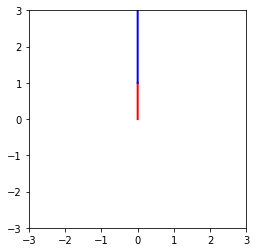

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML  # Import HTML for displaying the animation in Jupyter

def FK(state):
    l1, l2 = 1.0, 2.0
    th1, th2 = state[:2]
    x1 = l1 * np.sin(th1)
    y1 = -l1 * np.cos(th1)
    x2 = l2 * np.sin(th1 + th2) + x1
    y2 = -l2 * np.cos(th1 + th2) + y1
    return x1, y1, x2, y2

n_frames = state_log.shape[0]

# Create the figure and axis for plotting
fig, ax = plt.subplots()
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_aspect('equal')

# Initialize the plot lines
line1, = ax.plot([], [], 'r-', lw=2)  # First segment (link 1)
line2, = ax.plot([], [], 'b-', lw=2)  # Second segment (link 2)

# Function to initialize the plot (empty frame)
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return line1, line2

# Function to update the plot for each frame
def update(frame):
    state = state_log[frame, :]
    x1, y1, x2, y2 = FK(state)

    # Update the line data for both segments
    line1.set_data([0, x1], [0, y1])  # First link (from origin to first joint)
    line2.set_data([x1, x2], [y1, y2])  # Second link (from first joint to second joint)
    
    return line1, line2

# Create the animation
ani = FuncAnimation(fig, update, frames=range(n_frames), init_func=init, blit=True, interval=50)
ani.save("/home/malkstik/mnt/results/acrobot_exact_dynamics.gif")
HTML(ani.to_jshtml())
plt.show()

# for state in state_log:
#     x1, y1, x2, y2 = FK(state)
#     print(state[0], state[1])
#     print(x1, y1, x2, y2)
#     print()

In [96]:
from control.AcrobotControllers import AcrobotiLQRController, AcrobotLQRController
from control.UtilLeafSystems import NonConstantVectorSource

builder = DiagramBuilder()
acrobot = builder.AddSystem(AcrobotPlant())
goal_state_source = builder.AddSystem(NonConstantVectorSource(4))

Q = np.diag(np.concatenate(([1.0] * 2, [0.1] * 2)))
Qf = np.diag(np.concatenate(([100.0] * 2, [100.0] * 2)))
R = np.diag([0.01])
dt = 0.05
N = 40

iLQRParams = {
    "Q" : Q,
    "R" : R,
    "Qf" : Qf,
    "N" : N,
    "dt" : dt,
    "max_iter" : 20,
    "max_linesearch_iters": 10,
    "integration": "RK4",
}

controller = builder.AddSystem(AcrobotiLQRController(**iLQRParams))
# controller = builder.AddSystem(AcrobotLQRController(**iLQRParams))

builder.Connect(
    acrobot.get_output_port(0), controller.get_input_port(0)
    )
builder.Connect(
    controller.get_output_port(0), acrobot.get_input_port(0)
    )
builder.Connect(
    goal_state_source.get_output_port(), controller.get_input_port(1)
    )
# Setup visualization
scene_graph = builder.AddSystem(SceneGraph())
AcrobotGeometry.AddToBuilder(builder, acrobot.get_output_port(0), scene_graph)
meshcat.Delete()
meshcat.Set2dRenderMode(xmin=-4, xmax=4, ymin=-4, ymax=4)
MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

diagram = builder.Build()


def simulate(diagram):
    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # Simulate
    simulator.set_target_realtime_rate(1.0)
    duration = 10.0
    ref_state = np.array([np.pi, 0., 0., 0.])
    goal_state_source.SetState(ref_state)
    for i in range(5):
        context.SetTime(0.0)
        context.SetContinuousState(
            ref_state
            + 0.5
            * np.random.randn(
                4,
            )
        )
        # context.SetContinuousState(np.array([np.pi/3, , 0.0, 0.0]))
        simulator.Initialize()
        simulator.AdvanceTo(duration)

simulate(diagram)



[ 2.83752219  0.79534074  0.01988036 -0.20549338]
[ 2.83752318  0.79533046  0.01803391 -0.20179173]
Awefaewf
[ 2.8375238   0.79532093  0.02000155 -0.20572394]
Awefaewf
[ 2.83752219  0.79534074  0.01988036 -0.20549338]
Awefaewf
[ 2.83752282  0.79533414  0.02005737 -0.20584379]
Awefaewf
[ 2.83752349  0.79532749  0.01963334 -0.20499125]
Awefaewf
[ 2.83752219  0.79534074  0.01988036 -0.20549338]
Awefaewf
[ 2.83752254  0.79533708  0.01989523 -0.20552099]
Awefaewf
[ 2.83752289  0.79533342  0.01815583 -0.20203749]
Awefaewf
[ 2.83752219  0.79534074  0.01988036 -0.20549338]
Awefaewf
[ 2.83752236  0.79533891  0.01966891 -0.20506911]
Awefaewf
[ 2.83752253  0.7953371   0.02033306 -0.20639732]
Awefaewf
[ 2.83752219  0.79534074  0.01988036 -0.20549338]
Awefaewf
[ 2.8375223   0.79533959  0.01988503 -0.20550206]
Awefaewf
[ 2.83752241  0.79533844  0.01933819 -0.20440689]
Awefaewf
[ 2.83752219  0.79534074  0.01988036 -0.20549338]
Awefaewf
[ 2.83752227  0.79533989  0.01978255 -0.20529712]
Awefaewf
[ 2.83

LinAlgError: Array must not contain infs or NaNs